In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib qt 

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2]=np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        if idx == np.random.randint(0, 20):
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # write_name = 'output_images/corners_found'+str(idx)+'.jpg'
            # cv2.imwrite(write_name, img)
            # cv2.imshow('img', img)
            plt.imshow(img)        
            plt.show()
#             cv2.waitKey(500)
img = cv2.imread('./camera_cal/calibration4.jpg')
img_size = (img.shape[1], img.shape[0]) 
x_size = img_size[0]
y_size = img_size[1]
# Do camera calibration given object points and image points
ret, camera_mtx, camera_dist, camera_rvecs, camera_tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, camera_mtx, camera_dist, None, camera_mtx)
cv2.imwrite('./output_images/calibration1_undist.jpg', dst)

True

In [2]:
img2 = cv2.imread('./output_images/test2.jpg')
img2_size = (img2.shape[1], img2.shape[0]) 
dst = cv2.undistort(img2, camera_mtx, camera_dist, None, camera_mtx)
cv2.imwrite('./output_images/test2_undist.jpg', dst)

True

In [3]:
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def image_mask(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = np.copy(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #because this uses mpimg to read image
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'*1) + int(orient=='y'*0),int(orient=='x'*0) + int(orient=='y'*1))
    sobel = np.absolute(sobel)
    sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel >= thresh[0])&(sobel <= thresh[1])] = 1
    return grad_binary

# def oneColor_thresh(image, color=2, thresh=(200, 255)):
#     # Calculate directional gradient
#     # Apply threshold
#     img = image[:,:,color]
#     oneColor_binary = np.zeros_like(img)
#     oneColor_binary[(img >= thresh[0])&(img <= thresh[1])] = 1
#     return oneColor_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    image = np.copy(img)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = np.uint8(255*sobel/np.max(sobel))
    mag_binary = np.zeros_like(sobel_x)
    mag_binary[(sobel>=mag_thresh[0])&(sobel<=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    image = np.copy(img)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def hls_filter(image, s_thresh=(170, 255)):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:, :, 2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary

# Define perspective transform function
def warp_image(img):
    img_size = (img.shape[1], img.shape[0])   
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    return warped

def color_filter(img, para):
    # Convert to HLS color space and separate the V channel
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,1]
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2] 

    # Threshold color channel
    s_thresh_min = para['s_min']
    l_thresh_s = para['l_s']
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (l_channel >= l_thresh_s)] = 1

    b_thresh_min = para['b_min']
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min)] = 1

    l_thresh_min = para['l_min']
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min)] = 1
    
    color_binary = np.zeros_like(l_channel)
    color_binary[(s_binary==1) | (b_binary==1)|(l_binary==1)] = 1
    return color_binary

def sobel_filter(img, para):
    ksize = 5
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=para['grad_thresh'])
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=para['grad_thresh'])
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=para['mag_min'])
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=para['dir_thresh'])

    sobel_binary = np.zeros_like(gradx)
    sobel_binary[(gradx == 1) & (mag_binary == 1) & (mag_binary == 1)] = 1
    return sobel_binary

def color_sobel(img, para):
    sobel_binary = sobel_filter(img, para)
    color_binary = color_filter(img, para)
    color_sobel = np.zeros_like(sobel_binary)
    color_sobel[(sobel_binary ==1) | (color_binary ==1)] = 1
    return color_sobel

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    hist = np.sum(image[int(image.shape[0]/2):, :], axis=0)
    mid = int(hist.shape[0]/2)
    l_center = np.argmax(hist[:mid])
    r_center = np.argmax(hist[mid:]) + mid
    car_width = 540

#     direction_sum = 0

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
    # convolve the window into the vertical slice of the image
    #     image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
    #     conv_signal = np.convolve(window, image_layer)
    #     # Find the best left centroid by using past left center as a reference
    #     # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
    #     offset = window_width/2
        y_start = int(image.shape[0]-(level+1)*window_height)
        y_end = int(image.shape[0]-level*window_height)
        hist = np.sum(image[y_start:y_end, :], axis=0)
        hist[hist<10] = 0
        left_min = l_center - margin
        left_max = l_center + margin
        right_min = r_center - margin
        right_max = r_center + margin
        left_box_center = np.argmax(hist[left_min:left_max])
        right_box_center = np.argmax(hist[right_min:right_max])
#         direction_sum += left_box_center + left_min + right_box_center + right_min - l_center - r_center
        if left_box_center > 10:
            l_center = left_box_center + left_min
#         else:
#             l_center += direction_sum/level
        if right_box_center > 10:
            r_center = right_box_center + right_min
#         else:
#             l_center += direction_sum/level
        window_centroids.append((l_center,r_center))
        
    return window_centroids

def process_image(sr_img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img = cv2.undistort(sr_img, camera_mtx, camera_dist, None, camera_mtx)
    # apply gaussian blur 
    blur_size = 5
    img = gaussian_blur(img, blur_size)
    
    # hard code the thresholds
    para ={'s_min': 100,
           'l_s': 40,
           'b_min': 160,
           'l_min': 190,
           'grad_thresh': (20, 255),
           'mag_min': (40, 255),
           'dir_thresh':(0.7, 1.4)}

    warped = color_sobel(warp_image(img), para)

    # find the lines and fit
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # fitting the lane lines and measuring curvature
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    rev_win_cen = window_centroids[::-1]
    leftx = np.array([rev_win_cen[int(y//window_height)][0] + np.random.randint(-40, high=41)
                                  for y in ploty])
    rightx = np.array([rev_win_cen[int(y//window_height)][1] + np.random.randint(-40, high=41)
                                    for y in ploty])
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    off_center = (left_fitx[-1] + right_fitx[-1] - x_size)/2.0/(right_fitx[-1] - left_fitx[-1])*370 # assume lane width is 370cm
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0]))
    result = cv2.addWeighted(sr_img, 1, newwarp, 0.5, 0)
    if off_center < 0:
        cv2.putText(result, 'Vehicle is {:.2f}cm left of center'.format(abs(off_center)), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}cm right of center'.format(abs(off_center)), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {:.2f}(km)'.format(int((left_curverad + right_curverad)/2)/1000), (120,140),
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    return result

In [4]:
# define the 4 corners for perspective image
# source corners
src_corners = np.array([[580, 460], 
                        [205, 720], 
                        [1110, 720], 
                        [703, 460]])

# desternation corners
dst_corners = np.array([[320, 0], 
                        [320, 720], 
                        [960, 720], 
                        [960, 0]])

# image warp parameters
# Four source coordinates
src = np.float32(src_corners)
# Four desired coordinates
dst = np.float32(dst_corners)
# Compute the perspective transform, M
M = cv2.getPerspectiveTransform(src, dst)
# Could compute the invert also by swapping the input parameters
Minv = cv2.getPerspectiveTransform(dst, src)

# window settings
window_width = 200 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

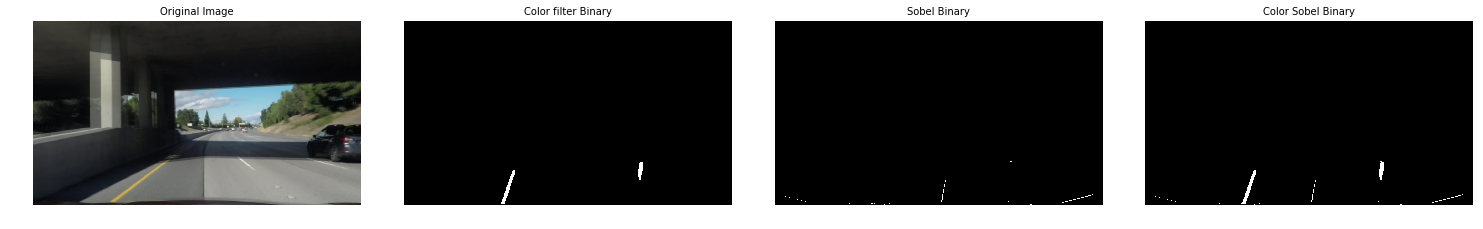

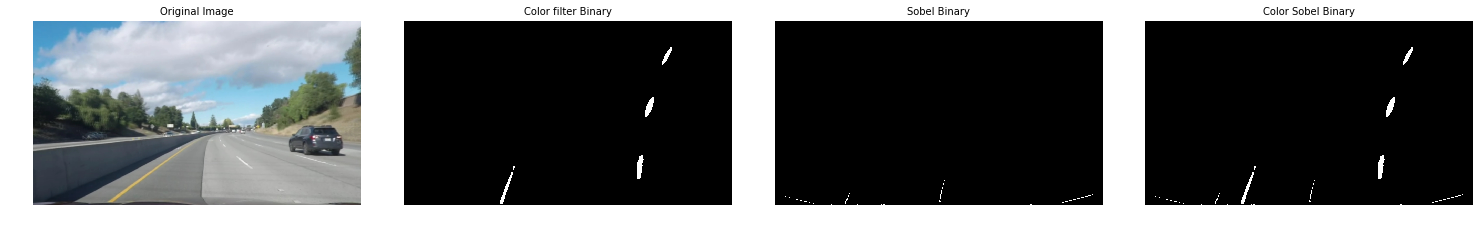

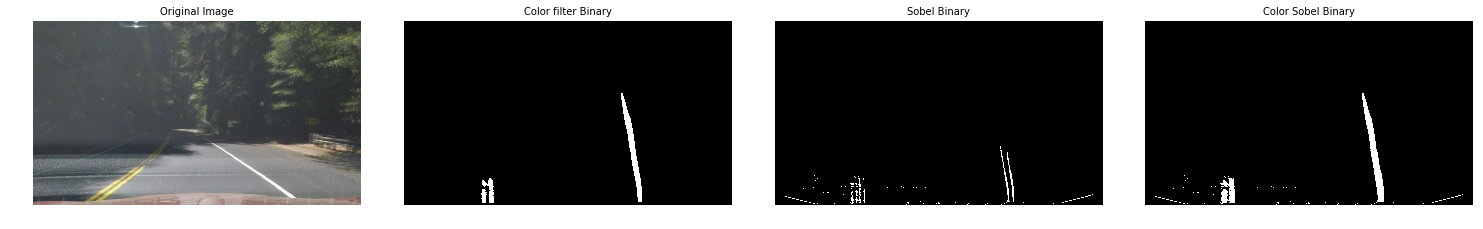

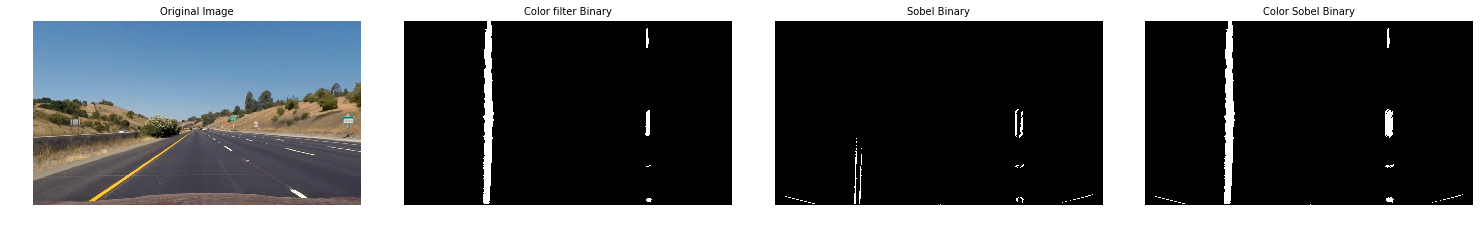

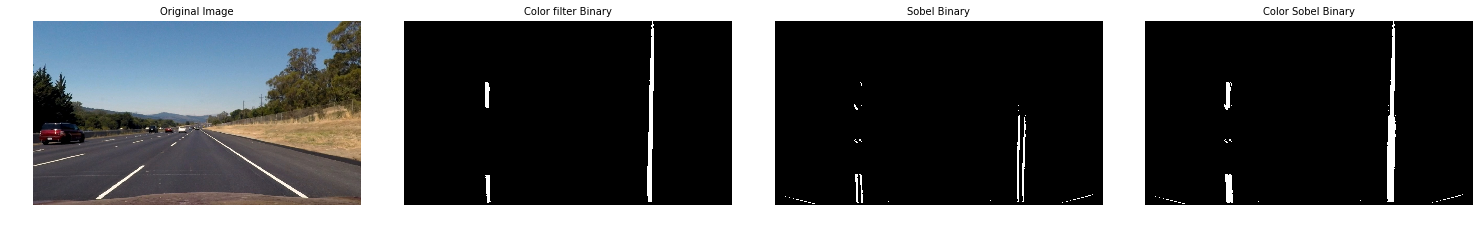

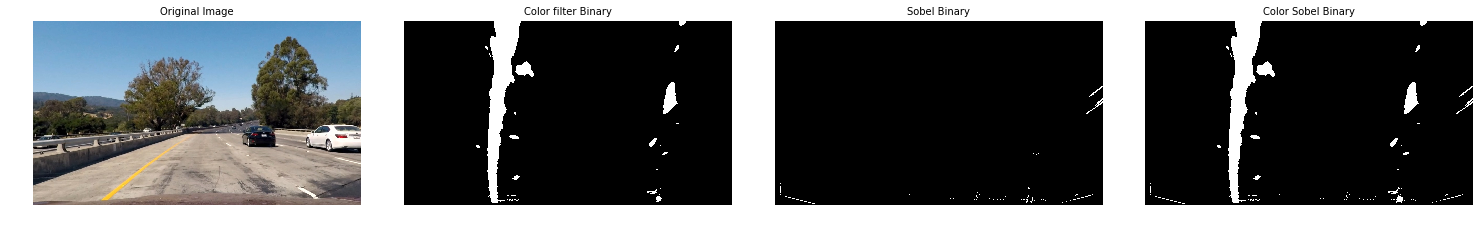

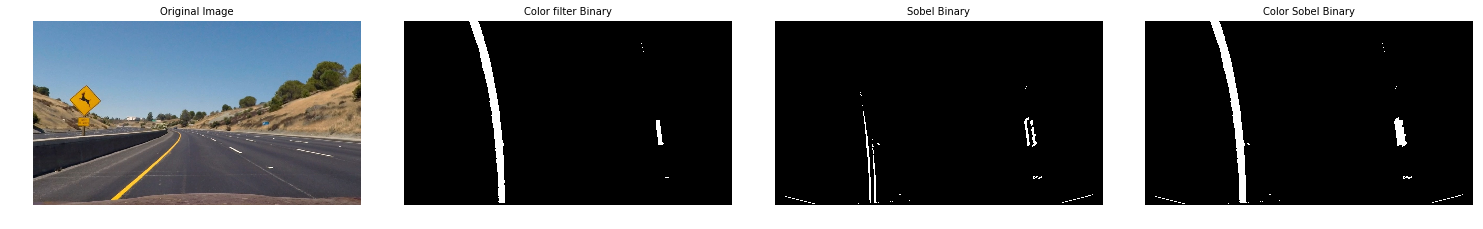

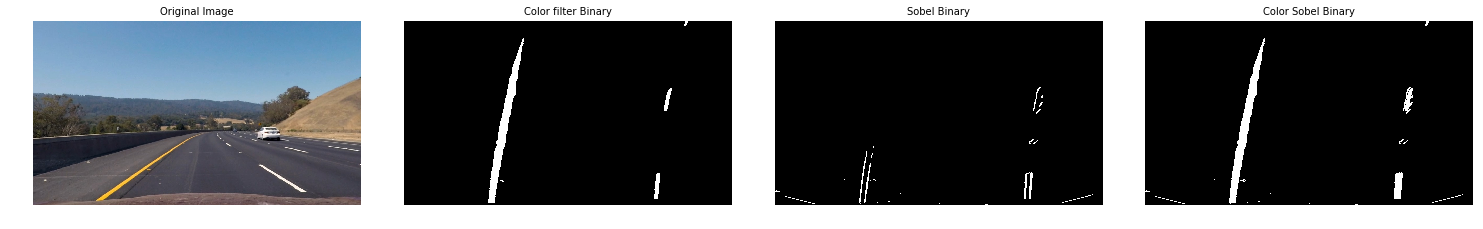

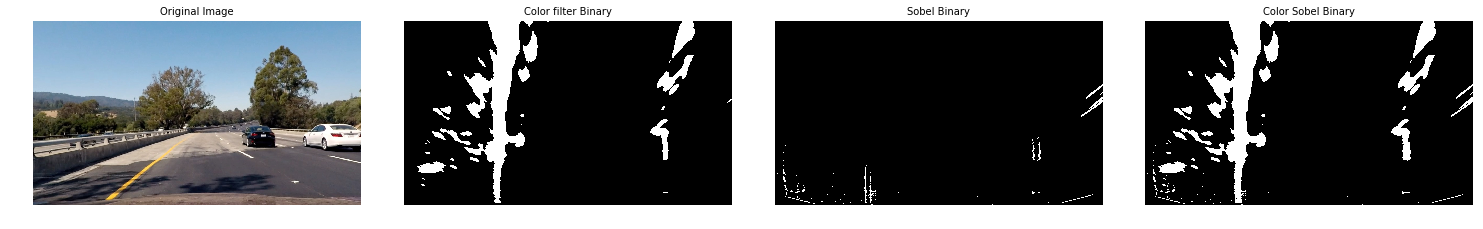

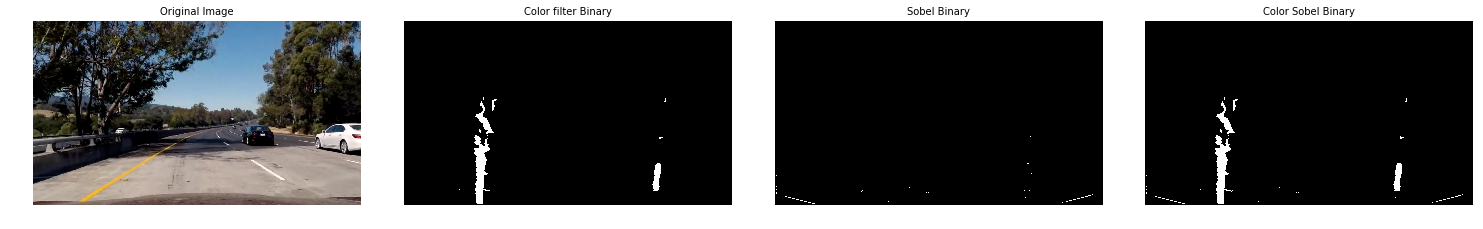

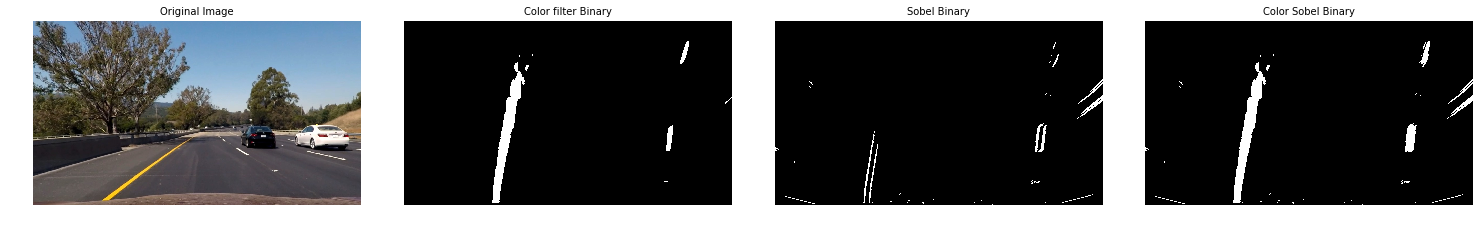

In [5]:
test_imgs = glob.glob('./test_images/*.jpg')

para ={'s_min': 100,
       'l_s': 40,
       'b_min': 160,
       'l_min': 195,
       'grad_thresh': (20, 255),
       'mag_min': (40, 255),
       'dir_thresh':(0.7, 1.4)}

for i in range(len(test_imgs)):
    sr_img = mpimg.imread(test_imgs[i])
    sr_img = cv2.undistort(sr_img, camera_mtx, camera_dist, None, camera_mtx)
    img = np.zeros_like(sr_img)
    img = cv2.normalize(sr_img,  img, 0, 255, cv2.NORM_MINMAX)

    # draw 
    blur_size = 5
    gaussian = gaussian_blur(img, blur_size)
    img = gaussian
    
#     masked = image_mask(img, vertices)
#     img = masked

    warped = warp_image(img)
    img = warped
    
    final = color_sobel(img, para)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 4))
    # f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(12, 8))
    f.tight_layout()
    ax1.imshow(sr_img)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax2.imshow(color_filter(img, para), cmap='gray')
    ax2.set_title('Color filter Binary', fontsize=10)
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax3.imshow(sobel_filter(img, para), cmap='gray')
    ax3.set_title('Sobel Binary', fontsize=10)
    ax3.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax4.imshow(color_sobel(img, para), cmap='gray')
    ax4.set_title('Color Sobel Binary', fontsize=10)
    ax4.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

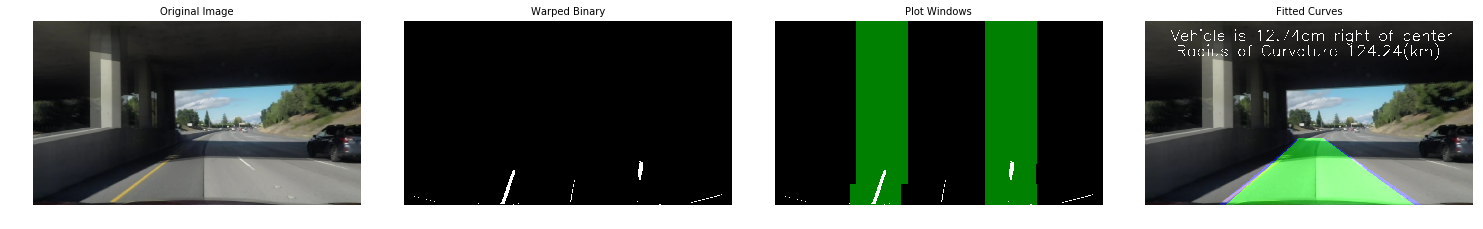

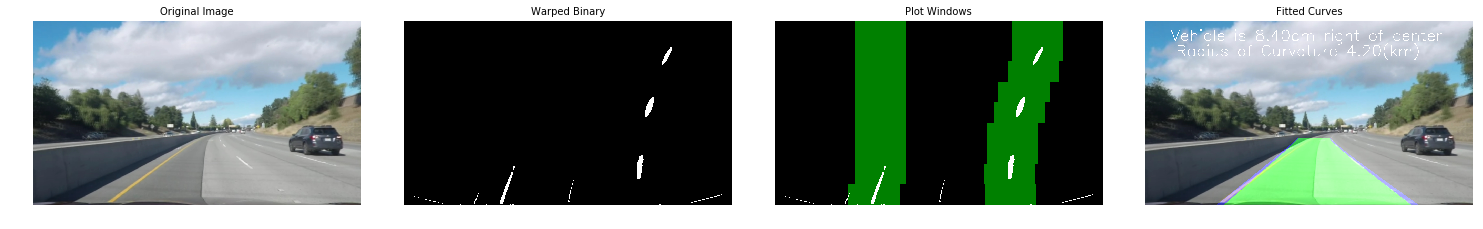

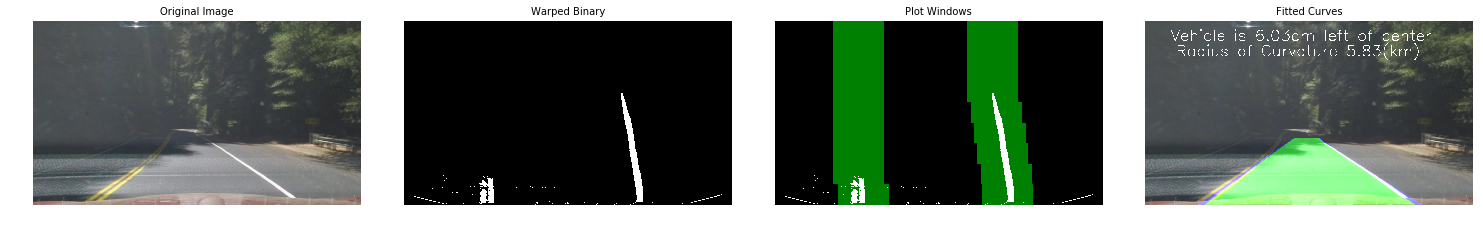

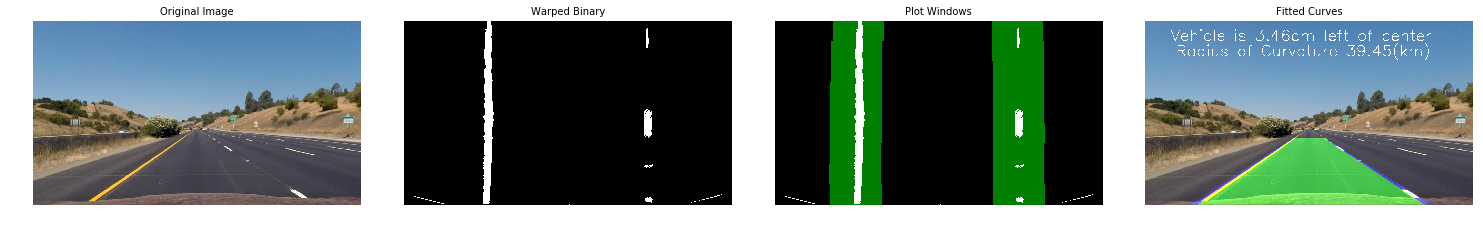

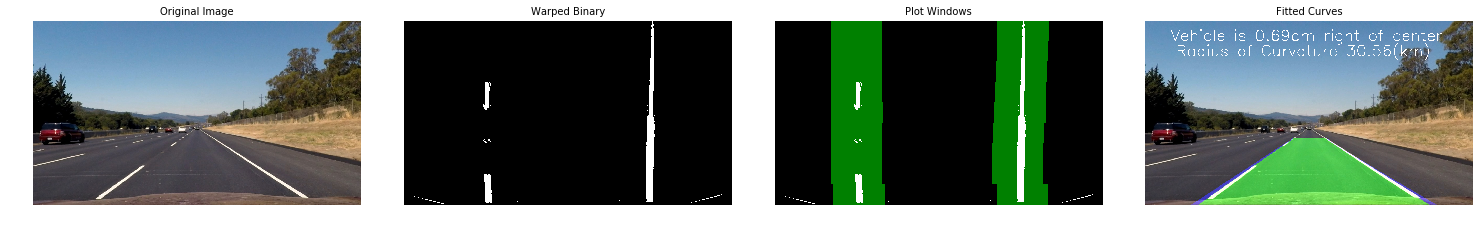

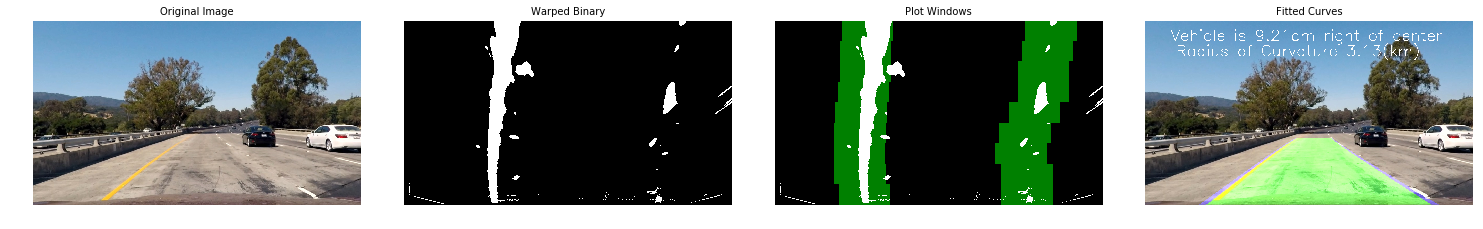

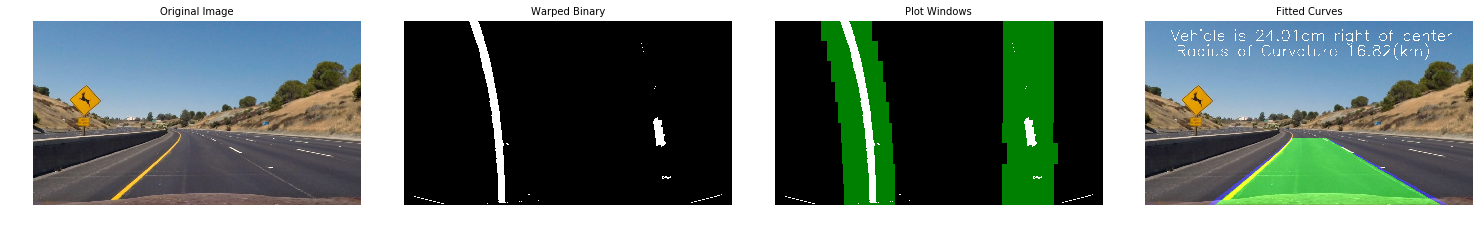

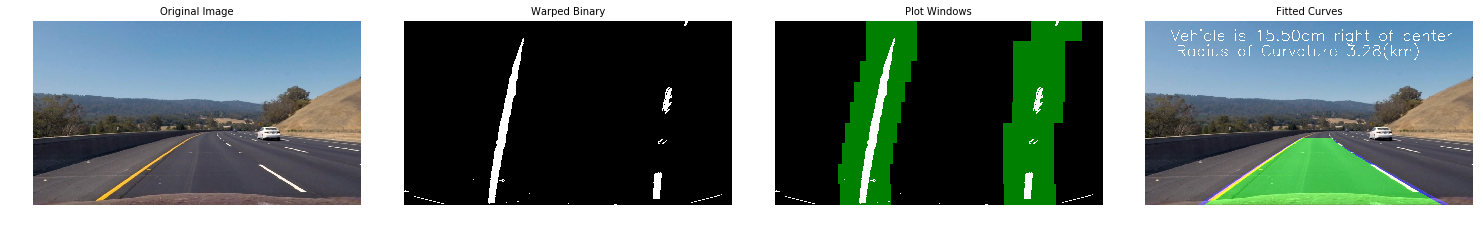

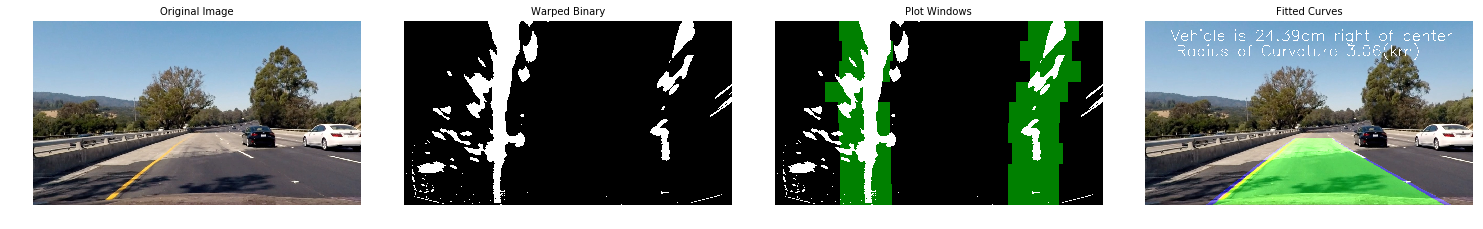

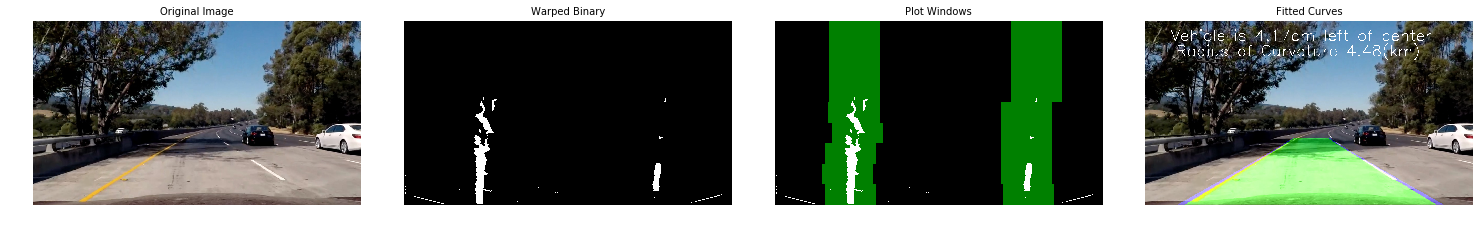

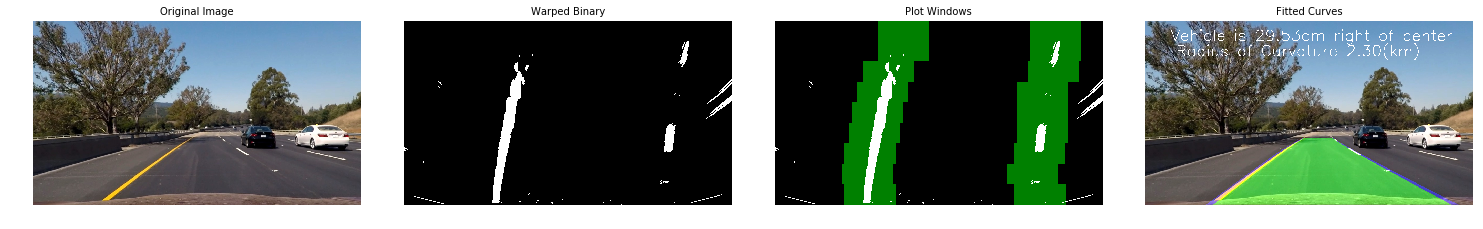

In [6]:
for i in range(len(test_imgs)):
    sr_img = mpimg.imread(test_imgs[i])
    sr_img = cv2.undistort(sr_img, camera_mtx, camera_dist, None, camera_mtx)
    img = np.zeros_like(sr_img)
    img = cv2.normalize(sr_img,  img, 0, 255, cv2.NORM_MINMAX)

    # draw 
    blur_size = 5
    gaussian = gaussian_blur(img, blur_size)
    img = gaussian
    
#     masked = image_mask(img, vertices)
#     img = masked

    warped = warp_image(img)
    img = warped
    
    final = color_sobel(img, para)
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    image = final

    # Sum quarter bottom of image to get slice, could use a different ratio
    hist = np.sum(image[int(image.shape[0]/2):, :], axis=0)
    mid = int(hist.shape[0]/2)
    l_center = np.argmax(hist[:mid])
    r_center = np.argmax(hist[mid:]) + mid
    car_width = 540

    direction = 0

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
    # convolve the window into the vertical slice of the image
    #     image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
    #     conv_signal = np.convolve(window, image_layer)
    #     # Find the best left centroid by using past left center as a reference
    #     # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
    #     offset = window_width/2
        y_start = int(image.shape[0]-(level+1)*window_height)
        y_end = int(image.shape[0]-level*window_height)
        hist = np.sum(image[y_start:y_end, :], axis=0)
        hist[hist<10] = 0
        left_min = l_center - margin
        left_max = l_center + margin
        right_min = r_center - margin
        right_max = r_center + margin
        left_box_center = np.argmax(hist[left_min:left_max])
        right_box_center = np.argmax(hist[right_min:right_max])
        if left_box_center > 10:
            l_center = left_box_center + left_min
        if right_box_center > 10:
            r_center = right_box_center + right_min
        window_centroids.append((l_center,r_center))
    
    warped = image
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 200) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case
    rev_win_cen = window_centroids[::-1]
    leftx = np.array([rev_win_cen[int(y//window_height)][0] + np.random.randint(-40, high=41)
                                  for y in ploty])
    rightx = np.array([rev_win_cen[int(y//window_height)][1] + np.random.randint(-40, high=41)
                                    for y in ploty])

    # leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    # rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    off_center = (left_fitx[-1] + right_fitx[-1] - x_size)/2.0/(right_fitx[-1] - left_fitx[-1])*370 # assume lane width is 370cm
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(sr_img, 1, newwarp, 0.5, 0)
    if off_center < 0:
        cv2.putText(result, 'Vehicle is {:.2f}cm left of center'.format(abs(off_center)), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}cm right of center'.format(abs(off_center)), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {:.2f}(km)'.format(int((left_curverad + right_curverad)/2)/1000), (120,140),
                fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
#     return result

    # Display the final results

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 4))
    # f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(12, 8))
    f.tight_layout()
    ax1.imshow(sr_img)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax2.imshow(image, cmap='gray')
    ax2.set_title('Warped Binary', fontsize=10)
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax3.imshow(output, cmap='gray')
    ax3.set_title('Plot Windows', fontsize=10)
    ax3.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    ax4.imshow(result, cmap='gray')
    ax4.set_title('Fitted Curves', fontsize=10)
    ax4.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
# Import everything needed to edit/save/watch video clips
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:42<00:00,  4.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [8]:
# Work on the challenge video
white_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# clip1 = VideoFileClip("challenge_video.mp4").subclip(0,16)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:46<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



## Example of convert undistored image to binary 

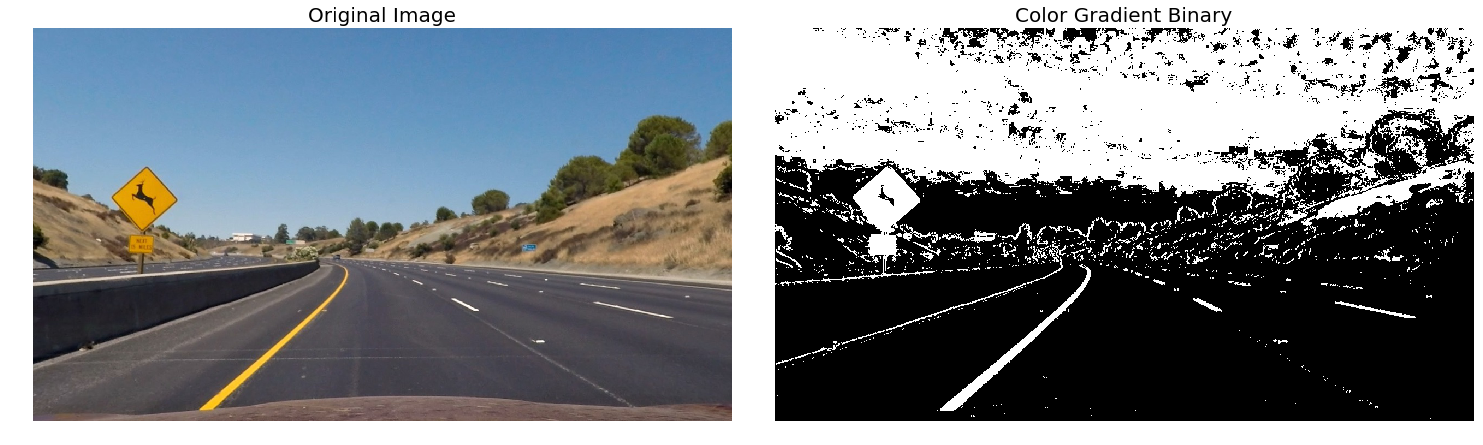

In [7]:
test_image = mpimg.imread('./output_images/test2_undist.jpg')

para ={'s_min': 100,
       'l_s': 40,
       'b_min': 160,
       'l_min': 195,
       'grad_thresh': (20, 255),
       'mag_min': (40, 255),
       'dir_thresh':(0.7, 1.4)}
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()
ax1.imshow(test_image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax2.imshow(color_sobel(test_image, para), cmap='gray')
ax2.set_title('Color Gradient Binary', fontsize=20)
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

 # This is an example of birdview

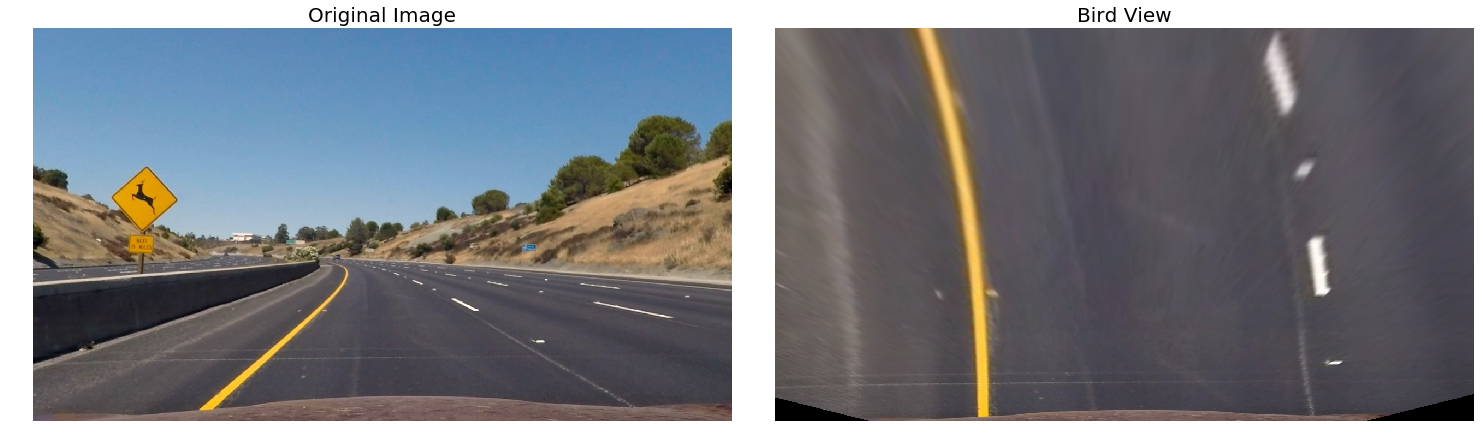

In [8]:
test_image = mpimg.imread('./output_images/test2_undist.jpg')

%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
f.tight_layout()
ax1.imshow(test_image)
ax1.axis('off')
ax1.set_title('Original Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax2.imshow(warp_image(test_image), cmap='gray')
ax2.set_title('Bird View', fontsize=20)
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)